In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [3]:
# Read data
df = pd.read_csv("./InputData/historical_data.csv")

# Inspection

In [4]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0000,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0000,4,3441,4,557,1239,33.0000,14.0000,21.0000,446,861.0000
1,2.0000,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0000,1,1900,1,1400,1400,1.0000,2.0000,2.0000,446,690.0000
2,3.0000,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0000,1,1900,1,1900,1900,1.0000,0.0000,0.0000,446,690.0000
3,3.0000,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0000,6,6900,5,600,1800,1.0000,1.0000,2.0000,446,289.0000
4,3.0000,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0000,3,3900,3,1100,1600,6.0000,6.0000,9.0000,446,650.0000


- market_id: City / region
- order_protocol: The channel from which the order was received
- subtotal, min, max price: In cents.
- total_onshift_dashers: Number of Dashers within 10 miles of the order at creation
- total_busy_dashers: Subset of the above which are currently working on another order
- total_outstanding_orders: Number of orders being processed within 10 miles
- estimated_order_place_duration: Estimated time it took for the restaurant to receive the order from DoorDash (in seconds)
- estimated_store_to_consumer_driving_duration: In seconds.

In [5]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.0000,197428.0000,196433.0000,197428.0000,197428.0000,197428.0000,197428.0000,197428.0000,181166.0000,181166.0000,181166.0000,197428.0000,196902.0000
mean,2.9787,3530.5103,2.8824,3.1964,2682.3314,2.6708,686.2185,1159.5886,44.8081,41.7397,58.0501,308.5602,545.3589
std,1.5249,2053.4967,1.5038,2.6665,1823.0937,1.6303,522.0386,558.4114,34.5268,32.1457,52.6618,90.1397,219.3529
min,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,-86.0000,0.0000,-4.0000,-5.0000,-6.0000,0.0000,0.0000
25%,2.0000,1686.0000,1.0000,2.0000,1400.0000,1.0000,299.0000,800.0000,17.0000,15.0000,17.0000,251.0000,382.0000
50%,3.0000,3592.0000,3.0000,3.0000,2200.0000,2.0000,595.0000,1095.0000,37.0000,34.0000,41.0000,251.0000,544.0000
75%,4.0000,5299.0000,4.0000,4.0000,3395.0000,3.0000,949.0000,1395.0000,65.0000,62.0000,85.0000,446.0000,702.0000
max,6.0000,6987.0000,7.0000,411.0000,27100.0000,20.0000,14700.0000,14700.0000,171.0000,154.0000,285.0000,2715.0000,2088.0000


- 197.428 rows
- Rows with zero subtotal?
- Rows with zero / negative min-max price? Doesn't make sense, drop
- Rows with negative Dashers / outstanding orders? As above
- Rows with zero estimated order placement & trip duration? Former's likely fine. Drop the latter below a certain value

In [6]:
# Threshold for driving duration
thresh_driving = 20

In [7]:
# Check missing values
pd.isnull(df).sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

- Drop all rows with missing values for sake of simplicity
- Drop rows with nonsensical / possibly false information (see above)
- Calculate target column: Delivery time in seconds
- Add features: Seasonal, number & proportion of non-busy dashers & interaction with outstanding orders...
- Convert datatypes: Categorical vs numeric
- Save full data
- Drop non-feature columns, save training data

# Preparation

## Missing / wrong values

In [8]:
# Drop all rows with missing values
df = df.dropna()

In [9]:
print(len(df))

175777


In [10]:
# Drop rows with zero subtotal
df = df[df["subtotal"] > 0]

In [11]:
# Drop rows without positive min-max price
df = df.loc[(df["min_item_price"] > 0) & (df["max_item_price"] > 0)]

In [12]:
# Drop rows with negative onshift-busy dashers, outstanding orders
df = df.loc[(df["total_onshift_dashers"] >= 0) & (df["total_busy_dashers"] >= 0) & (df["total_outstanding_orders"] >= 0)]

In [13]:
# Drop rows with very small estimated driving duration
df = df[df["estimated_store_to_consumer_driving_duration"] >= thresh_driving]

In [14]:
print(len(df))

173316


## Sanity checks

In [15]:
# subtotal >= max_item_price
df = df.loc[df["subtotal"] >= df["max_item_price"]]

In [16]:
# total_items >= num_distinct_items
df = df.loc[df["total_items"] >= df["num_distinct_items"]]

In [17]:
# if num_distinct_items == 1, then min_item_price == max_item_price
mask = df["num_distinct_items"] == 1 & (df["min_item_price"] != df["max_item_price"])
df = df[[not row for row in mask]]

In [18]:
print(len(df))

171102


In [19]:
# total_items * max_item_price >= subtotal >= total_items * min_item_price
df = df.loc[
    ((df["max_item_price"] * df["total_items"]) >= df["subtotal"]) & 
    (df["subtotal"] >= (df["min_item_price"] * df["total_items"]))
]

In [20]:
print(len(df))

141871


In [21]:
# total_busy_dashers <= total_onshift_dashers
df = df.loc[df["total_busy_dashers"] <= df["total_onshift_dashers"]]

In [22]:
print(len(df))

110516


In [23]:
# created_at < actual_delivery_time
df = df.loc[df["created_at"] < df["actual_delivery_time"]]

In [24]:
print(len(df))

110516


## Feature engineering

In [25]:
# Enforce variable types
df["market_id"] = df["market_id"].astype(str)
df["store_id"] = df["store_id"].astype(str)
df["order_protocol"] = df["order_protocol"].astype(str)

df["created_at"] = pd.to_datetime(df["created_at"])
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])

In [26]:
df.dtypes

market_id                                               object
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                object
store_primary_category                                  object
order_protocol                                          object
total_items                                              int64
subtotal                                                 int64
num_distinct_items                                       int64
min_item_price                                           int64
max_item_price                                           int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_order_place_duration                           int64
estimated_store_to_consumer_driving_duration           

In [27]:
# Order by creation date
df = df.sort_values("created_at")

In [28]:
df["created_at"]

43519    2015-01-21 15:22:03
10265    2015-01-21 15:40:42
155462   2015-01-21 15:46:41
176488   2015-01-21 15:52:32
9521     2015-01-21 16:00:44
                 ...        
197232   2015-02-18 05:54:18
22282    2015-02-18 05:54:41
164423   2015-02-18 05:55:00
19372    2015-02-18 05:55:10
20772    2015-02-18 05:56:42
Name: created_at, Length: 110516, dtype: datetime64[ns]

Time period
- One year
- January 21 15:00 to February 18 05:56

Time features
- Day of week, dummy
- Hour of day, cyclical
- Minute of day, cyclical
- Feb 01 Superbowl, binary
- Feb 14 Valentine's, binary


In [29]:
# Add time features

# Day of week
dayofweek = pd.get_dummies(df.created_at.dt.weekday, prefix = "weekday").astype(int)
df = pd.concat([df, dayofweek], axis = 1)

# Hour of day
hourofday = df.created_at.dt.hour
df["hour_sin"] = np.sin(2 * np.pi * hourofday / 24)
df["hour_cos"] = np.cos(2 * np.pi * hourofday / 24)

# Minute of day
minofday = df.created_at.dt.hour * 60 + df.created_at.dt.minute
df["minute_sin"] = np.sin(2 * np.pi * minofday / 1440)
df["minute_cos"] = np.cos(2 * np.pi * minofday / 1440)

# Superbowl
df["superbowl"] = ((df.created_at.dt.month == 2) & (df.created_at.dt.day == 1)).astype(int)

# Valentines Day
df["valentines"] = ((df.created_at.dt.month == 2) & (df.created_at.dt.day == 14)).astype(int)

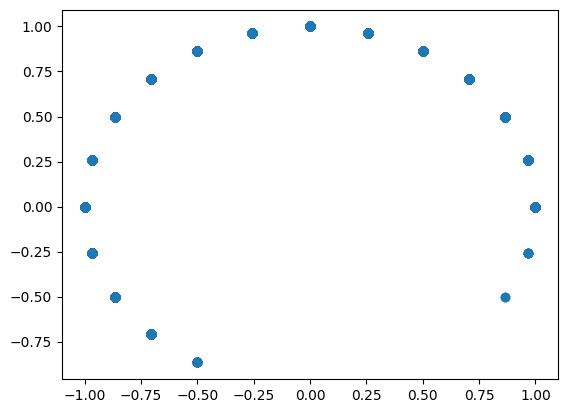

In [30]:
_ = plt.scatter(df["hour_sin"], df["hour_cos"])

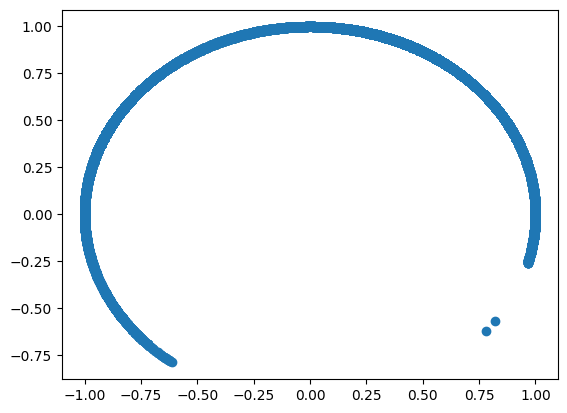

In [31]:
_ = plt.scatter(df["minute_sin"], df["minute_cos"])

In [32]:
hourofday.nunique()

19

In [33]:
minofday.nunique()

982

In [34]:
# Add interaction features

# Number of available dashers
df["total_available_dashers"] = df["total_onshift_dashers"] - df["total_busy_dashers"]

# Proportion of busy dashers
df["ratio_busy_dashers"] = (df["total_busy_dashers"] + 1) / (df["total_onshift_dashers"] + 1)

# "Business score"
df["busy_score"] = df["ratio_busy_dashers"] * df["total_outstanding_orders"]

# Export prepared data

In [35]:
# Add target column: Delivery duration in seconds
df["duration"] = (df.actual_delivery_time - df.created_at).dt.seconds

In [36]:
# Save full data
df.to_csv("./InputData/full_data.csv", index = False)